In [1]:
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import pandas as pd
from scripts.utils import *

2021-10-14 09:47:00.738517: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-10-14 09:47:00.738533: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
df = pd.read_csv("data/concatenated/X_balanced.csv")
x_train,y_train,x_val,y_val,x_test,y_test,class_weight = split_and_shuffle(df)

Examples:
    Total: 224092
    P: 80056 (35.72% of total)
    S: 64346 (28.71% of total)
    W: 79690 (35.56% of total)

Weight for class 0: 1.40
Weight for class 1: 1.74
Weight for class 2: 1.41


In [2]:
train_df = pd.read_csv("train.csv")
val_df = pd.read_csv("val.csv")
test_df = pd.read_csv("test.csv")

y_test = test_df.pop('Class')
x_test = test_df
y_train = train_df.pop('Class')
x_train = train_df
y_val = val_df.pop('Class')
x_val = val_df

scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.fit_transform(x_val)
x_test = scaler.fit_transform(x_test)

x_train = np.array(x_train)
y_train = np.array(y_train)
x_val = np.array(x_val)
y_val = np.array(y_val)
x_test = np.array(x_test)
y_test = np.array(y_test)

In [3]:
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))
x_val = x_val.reshape((x_val.shape[0], x_val.shape[1], 1))


In [5]:
n_classes = len(np.unique(y_train))

In [6]:
idx = np.random.permutation(len(x_train))
x_train = x_train[idx]
y_train = y_train[idx]

In [11]:
input_shape = x_train.shape[1:]

model = build_model(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25
)

model.compile(
    loss="categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["categorical_accuracy"],
)
model.summary()

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_transformer2.h5", save_best_only=True, monitor="val_loss",verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1, restore_best_weights=True),
]
model.fit(
    x_train,
    tf.one_hot(y_train,depth=3),
    validation_data=(x_val,tf.one_hot(y_val,depth=3)),
    epochs=200,
    batch_size=64,
    callbacks=callbacks,
)



Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 42, 1)]      0                                            
__________________________________________________________________________________________________
multi_head_attention_12 (MultiH (None, 42, 1)        7169        input_4[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
dropout_31 (Dropout)            (None, 42, 1)        0           multi_head_attention_12[0][0]    
__________________________________________________________________________________________________
layer_normalization_24 (LayerNo (None, 42, 1)        2           dropout_31[0][0]           

KeyboardInterrupt: 

In [35]:
model.save("model.h5")

In [4]:
model = keras.models.load_model("best_transformer.h5")

test_loss, test_acc = model.evaluate(x_test, y_test)

print("Test accuracy", test_acc)

print("Test loss", test_loss)

2021-10-14 09:47:42.712787: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-10-14 09:47:42.712821: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2021-10-14 09:47:42.712837: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (RNA): /proc/driver/nvidia/version does not exist
2021-10-14 09:47:42.712972: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-10-14 09:47:43.069423: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimizati

1401/1401 [==============================] - 117s 83ms/step - loss: 0.4193 - sparse_categorical_accuracy: 0.8471
Test accuracy 0.8470515012741089
Test loss 0.4193164110183716


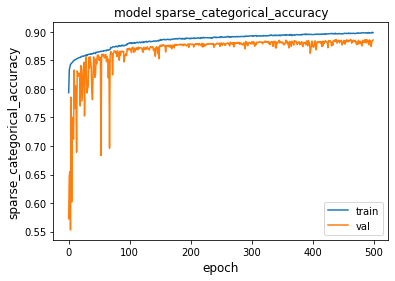

In [74]:
metric = "sparse_categorical_accuracy"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()